# Decomposed layer thickness gradients 

We split the layer thickness into two components: steady and unsteady. 

Steady corresponds to mean layer thickess and topographic effects, while the unsteady would correspond to the spatio-temporal variations that arise due to dynamics. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-01-30 20:52:00.222568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-30 20:52:00.240984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-30 20:52:00.246449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [98]:
# Experiment
experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':1, 
                    
                    'input_channels' : ['dudx',  
                                        'dvdx', 
                                        'dudy',
                                        'dvdy',
                                        'dhdx',
                                        'dhdy'],
                                        #'dhbardx_widened',
                                        #'dhbardy_widened',
                                        #'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
                    'sim_data_time_range': slice(0, 1200), 
                    'train_time_range': slice(0, 1000),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    'num_inputs': 8*9 + 1, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt_DG'
                    
            }

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels'])

experiment_config['num_inputs'] = (len(experiment_config['input_channels']) - 1)*experiment_config['window_size']**2 + 1

In [72]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'dedx_middle': ([], 1e-3),
    'dedy_middle': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),

    'dudx_nondim': ([], 1.),  # scalar value
    'dvdx_nondim': ([], 1.),
    'dudy_nondim': ([], 1.),
    'dvdy_nondim': ([], 1.),
    'dhdx_nondim': ([], 1.),
    'dhdy_nondim': ([], 1.),
    
    'uphp_nondim': ([], 1e-1),
    'vphp_nondim': ([], 1e-1),

    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dhbardx_widened': ([], 1e-3),
    'dhbardy_widened': ([], 1e-3),
    'dedx_middle_widened': ([], 1e-3),
    'dedy_middle_widened': ([], 1e-3),

    
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),

    'dudx_widened_nondim': ([], 1e-1),  # scalar value
    'dvdx_widened_nondim': ([], 1e-1),
    'dudy_widened_nondim': ([], 1e-1),
    'dvdy_widened_nondim': ([], 1e-1),
    'dhdx_widened_nondim': ([], 1e-1),
    'dhdy_widened_nondim': ([], 1e-1),
    'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1e-1),
    'dudy_widened_rotated_nondim': ([], 1e-1),
    'dvdy_widened_rotated_nondim': ([], 1e-1),
    'dhdx_widened_rotated_nondim': ([], 1e-1),
    'dhdy_widened_rotated_nondim': ([], 1e-1),
    'uphp_rotated_nondim': ([], 1e-5),
    'vphp_rotated_nondim': ([], 1e-5),
}

ds_norm = xr.Dataset(normalize_data_dic)

In [73]:
%%time
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'],
                             time_sel = experiment_config['sim_data_time_range'])

CPU times: user 25.5 s, sys: 3.7 s, total: 29.2 s
Wall time: 26.9 s


In [99]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.5136 gb into memory.
load took: 17.2757 seconds
Will load : 0.0328704 gb into memory.
load took: 2.6670 seconds


In [100]:
batch_xr = ML_DT_train.ml_batches[0]

In [101]:
batch_xr.std()

<xarray.Dataset> Size: 56B
Dimensions:  ()
Data variables:
    dudx     float64 8B 4.136e-07
    dvdx     float64 8B 9.013e-07
    dudy     float64 8B 6.257e-07
    dvdy     float64 8B 4.143e-07
    dhdx     float64 8B 0.0004333
    dhdy     float64 8B 0.0003596
    uphp     float32 4B 0.3972
    vphp     float32 4B 0.5934

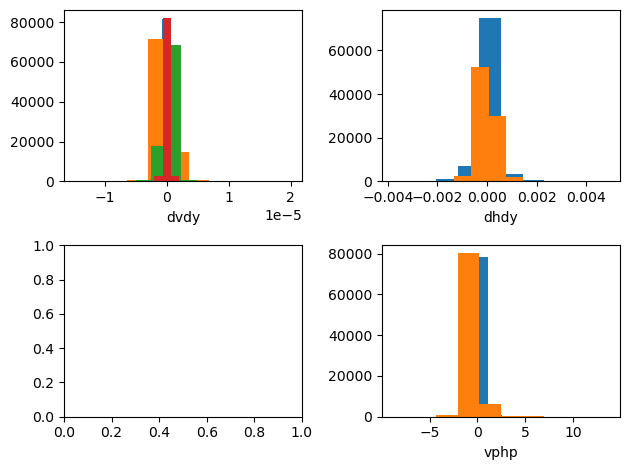

In [103]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
#batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [104]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [105]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (87840, 6)
Output (y) batch shape: (87840, 2)


In [106]:
num_in = batch_out['X'].shape[-1]
num_in

6

In [121]:
experiment_config['num_inputs']

6

In [107]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [108]:
ANN_model.count_parameters()

1658


In [109]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [110]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=31, print_freq=4)

At epoch 1. Train loss :  0.015711155266979256 , Test loss: 0.011469076946377754 , Test R2: -0.9511476039886475
At epoch 5. Train loss :  0.009683396365191485 , Test loss: 0.010518891364336013 , Test R2: -0.7893552303314209
At epoch 9. Train loss :  0.009319633421664303 , Test loss: 0.010189758241176605 , Test R2: -0.7333434820175171
At epoch 13. Train loss :  0.009108886399583236 , Test loss: 0.01006154678761959 , Test R2: -0.7115147829055786
At epoch 17. Train loss :  0.00901433709706809 , Test loss: 0.010018045082688332 , Test R2: -0.70412757396698
At epoch 21. Train loss :  0.008943743877918334 , Test loss: 0.009956074878573418 , Test R2: -0.6935921430587768
At epoch 25. Train loss :  0.00889177610342567 , Test loss: 0.0098971052095294 , Test R2: -0.683536434173584
At epoch 29. Train loss :  0.008846026971130757 , Test loss: 0.009869395196437836 , Test R2: -0.6788238048553467
CPU times: user 2min 43s, sys: 3.69 s, total: 2min 47s
Wall time: 1min 22s


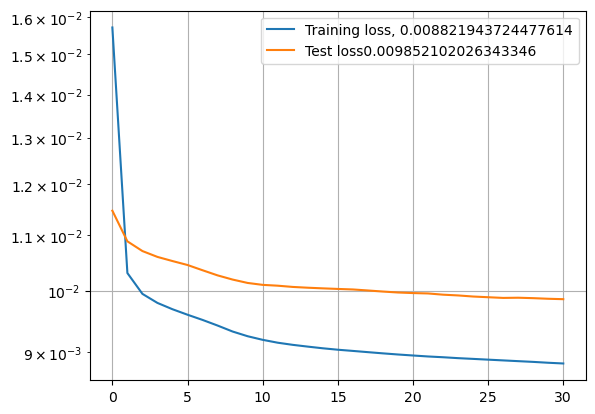

In [111]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.grid()
plt.yscale('log')
plt.legend()

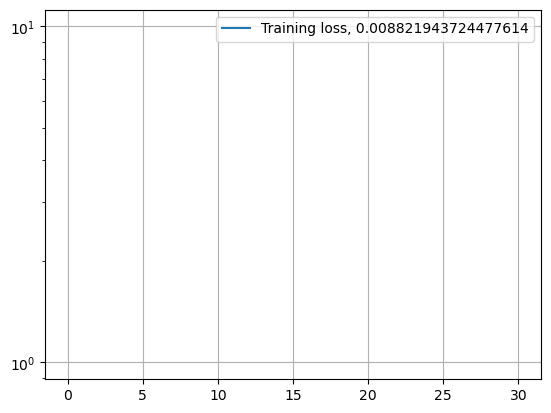

In [112]:
## Loss plot
plt.plot(regress_sys.test_R2, label='Training loss, '+str(regress_sys.train_loss[-1]))

plt.grid()
plt.yscale('log')
plt.legend()

In [118]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

In [124]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt_DG'

In [122]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])

In [123]:
# Spin up eval pack
test_eval.read_ann_regression_model()
test_eval.read_eval_data()
test_eval.predict()

ValueError: NOT_FOUND: Error opening "zarr" driver: Error reading "epoch/.zarray" in OCDBT database at local file "/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt_DG/": Error reading Byte range [9515, 10014) of local file "/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt_DG/d/dd6134863485434d2923aec29c8161c4" [tensorstore_spec='{\"context\":{\"cache_pool\":{},\"cache_pool#ocdbt\":{\"total_bytes_limit\":100000000},\"data_copy_concurrency\":{},\"file_io_concurrency\":{\"limit\":128},\"file_io_sync\":true,\"ocdbt_coordinator\":{}},\"driver\":\"zarr\",\"kvstore\":{\"base\":{\"driver\":\"file\",\"path\":\"/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt_DG/\"},\"cache_pool\":\"cache_pool#ocdbt\",\"driver\":\"ocdbt\",\"experimental_read_coalescing_interval\":\"1ms\",\"experimental_read_coalescing_merged_bytes\":500000000000,\"experimental_read_coalescing_threshold_bytes\":1000000,\"path\":\"epoch/\"},\"recheck_cached_data\":false,\"recheck_cached_metadata\":false}'] [source locations='tensorstore/internal/cache/kvs_backed_cache.h:208\ntensorstore/internal/cache/kvs_backed_cache.h:208\ntensorstore/driver/driver.cc:112']

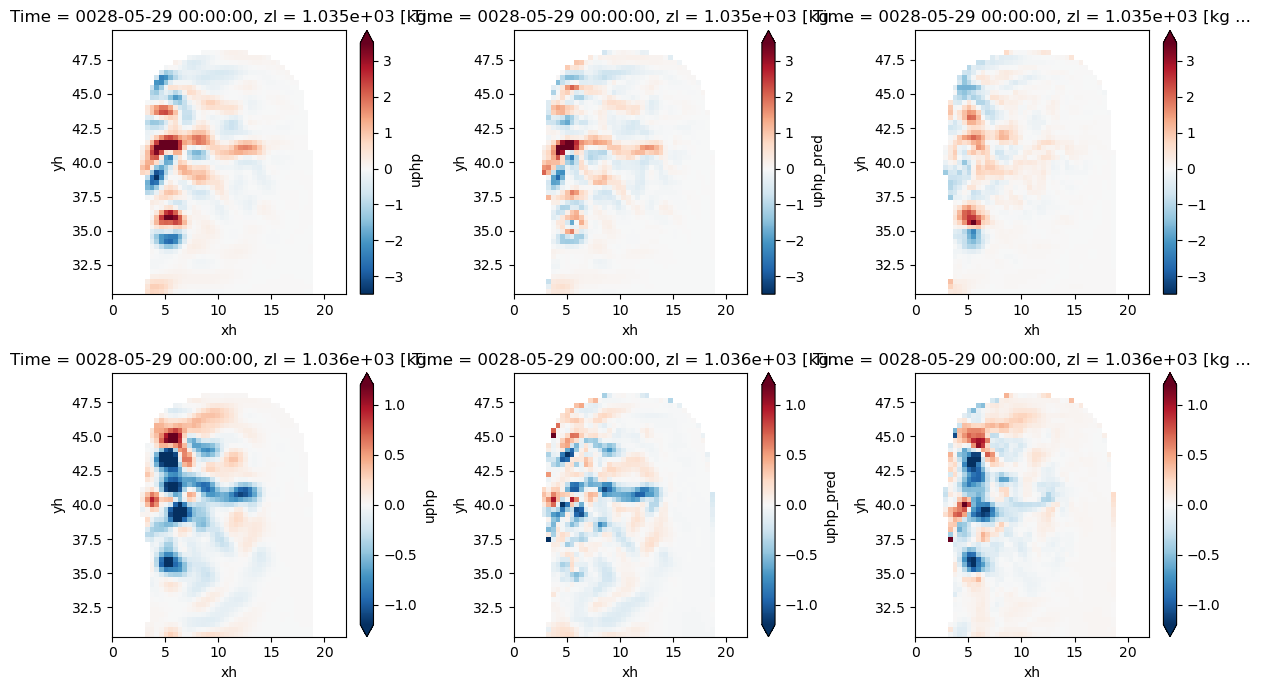

In [92]:
exp = experiment_config['simulation_names'][0]
scale = '200'

plt.figure(figsize=(12, 7))

vmin=-3.5
zl_choice = 0

plt.subplot(231)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(232)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred'].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(233)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred']).isel(Time=0, zl=0).plot(vmin=vmin)


vmin=-1.2 
zl_choice = 1

plt.subplot(234)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(235)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(236)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.tight_layout()

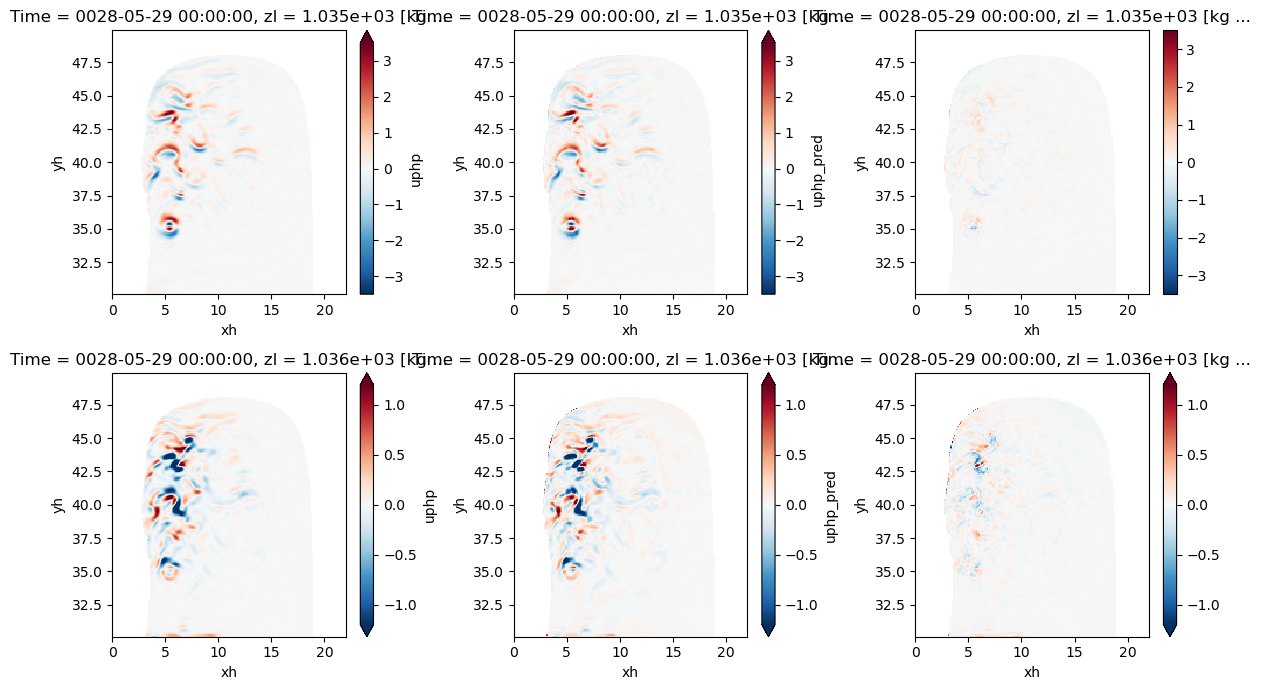

In [93]:
exp = experiment_config['simulation_names'][0]
scale = '50'

plt.figure(figsize=(12, 7))

vmin=-3.5
zl_choice = 0

plt.subplot(231)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(232)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred'].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(233)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred']).isel(Time=0, zl=0).plot(vmin=vmin)


vmin=-1.2 
zl_choice = 1

plt.subplot(234)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(235)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(236)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.tight_layout()

In [94]:
test_eval.calc_time_hor_space_metrics(yh_region=slice(31, 45), xh_region=slice(5, 17), dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp',yh_region=slice(31, 45), xh_region=slice(5, 17), dims=['Time','xh','yh'])

In [95]:
experiment_config['window_size']

1

In [96]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.91928914 0.90236831]
DG 50km, R2 for vphp is (layer:[0,1])[0.9370588  0.90039035]
DG 100km, R2 for uphp is (layer:[0,1])[0.85767568 0.70969837]
DG 100km, R2 for vphp is (layer:[0,1])[0.88302894 0.76673802]
DG 200km, R2 for uphp is (layer:[0,1])[0.68291043 0.5110929 ]
DG 200km, R2 for vphp is (layer:[0,1])[0.54836459 0.45026087]
DG 400km, R2 for uphp is (layer:[0,1])[0.48837077 0.45429429]
DG 400km, R2 for vphp is (layer:[0,1])[0.13146908 0.21704681]


In [97]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.91928914 0.90236831]
DG 50km, R2 for vphp is (layer:[0,1])[0.9370588  0.90039035]
DG 100km, R2 for uphp is (layer:[0,1])[0.85767568 0.70969837]
DG 100km, R2 for vphp is (layer:[0,1])[0.88302894 0.76673802]
DG 200km, R2 for uphp is (layer:[0,1])[0.68291043 0.5110929 ]
DG 200km, R2 for vphp is (layer:[0,1])[0.54836459 0.45026087]
DG 400km, R2 for uphp is (layer:[0,1])[0.48837077 0.45429429]
DG 400km, R2 for vphp is (layer:[0,1])[0.13146908 0.21704681]


In [28]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_all_space_time.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_all_space_time.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.97221204 0.96492808]
DG 50km, R2 for vphp is (layer:[0,1])[0.9776194  0.96585703]
DG 100km, R2 for uphp is (layer:[0,1])[0.97011571 0.93764852]
DG 100km, R2 for vphp is (layer:[0,1])[0.97483073 0.95178662]
DG 200km, R2 for uphp is (layer:[0,1])[0.93934135 0.83399339]
DG 200km, R2 for vphp is (layer:[0,1])[0.92204007 0.88617046]
DG 400km, R2 for uphp is (layer:[0,1])[0.86685536 0.81051499]
DG 400km, R2 for vphp is (layer:[0,1])[0.64723537 0.67356358]
